# **Final project** 
### **Оценка успешности A/B теста приложения**

## **Описание и Задача**

Есть дейтинг-приложение. Помимо базовых функций, в приложении есть премиум-подписка, которая дает доступ к расширенным возможностям.

**Был проведен A/B тест в нескольких странах по изменению двух платежных систем при покупке премиум-подписки.** 

**Условия A/B теста:**

Для новых пользователей из нескольких стран изменена стоимость премиум-подписки* при покупке через две новые платежные системы. 
При этом стоимость пробного периода оставалась прежней.

_*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит_

**Задача:**

**Оценить успешность эксперимента.**

## **Meta Data**

**Выборка состоит из трех групп: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2).**

**Файлы с данными:**

- users_test – информация о пользователях в тестовой группе
- users_control_1 – информация о пользователях в первой контрольной группе
- users_control_2 – информация о пользователях во второй контрольной группе 
- transactions_test – информация о платежах пользователей в тестовой группе 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

**Для каждой из групп:**

users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки / просмотры * 1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка

transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

## **Ход работы**

**1. Предварительный анализ данных:**

- Предобработка данных - проверка их на корректность, внесение изменений (при необходимости)
- Отбор целевых пользователей: новых, из определенных стран и с нужными платежными системами

**2. Оценка репрезентативности выборки:**

- Сравнение групп для оценки их сходства и достоверности ыборок.
- Построение графиков для визуализации данных и выявления возможных номалий.

**3. Проведение A/A/B тестов:**

- Определение гипотез ля проверки.
- Выбор подходящих статистических методо для анализа.
- Осуществление тестирования и сбоа результатов.

**4. Подведение итогов:**

- Формулирование выводов
- Ответ на заданный вопрос: был ли успешным эксперимент по изменению стоимости премиум-подписки в приложении?

## **1. Предварительный анализ данных**

#### **Импорт библиотек**

In [34]:
# Импорт основных библиотек
import pandas as pd         
import numpy  as np         
import requests             # для отправки HTTP-запросов и работы с веб-ресурсами и API
from io import BytesIO      # для работы с потоками байтов в памяти без необходимости сохранять их на диске
import datetime             # для работы с датами и временем
import gdown                # для скачивания данных с google диска

# Импорт статистических функций
import scipy.stats as ss
from scipy.stats import chi2_contingency, f_oneway, kruskal, ttest_ind, mannwhitneyu
import pingouin    as pg    # упрощает выполнение стат. тестов 

       # chi2_contingency: Хи-квадрат тест для проверки независимости категориальных переменных
       # f_oneway:         Однофакторный дисперсионный анализ (ANOVA)
       # kruskal:          Критерий Крускала — Уоллиса для проверки равенства медиан в независимых выборках
       # ttest_ind:        Тест Стьюдента для проверки разницы средних в двух независимых выборках
       # mannwhitneyu:     Тест Манна — Уитни для проверки разницы между двумя независимыми выборками (непараметрический аналог t-теста)

# Импорт библиотек для визуализации
import seaborn           as sns
import matplotlib.pyplot as plt

# для отображения графиков непосредственно в блокноте
%matplotlib inline         
sns.set_style("white")     # белый фон графиков без сетки 

# для управления предупреждениями 
import warnings                   
warnings.filterwarnings('ignore')

#### **Создание функций для последующей загрузки нужных csv-файлов с гугл-диска. Импорт данных.**

##### **1.1 Создание функций для загрузки данных**

In [13]:
# Извлечение ID-файла из ссылки на гугл-диске
import re

def extract_file_id(url):
    file_id_pattern = r"(?<=/d/)(.*?)(?=/|$)"
    match           = re.search(file_id_pattern, url)
    if match:
        return match.group(0)
    else:
        raise ValueError("Не удалось извлечь ID файла из URL")

In [18]:
# Скачивает файл с гугл-диска по URL и загружает его в датафрейм
def get_data(url, output_path=None):
    file_id = extract_file_id(url)                                   # Извлекаем ID файла из URL
    download_url = f'https://drive.google.com/uc?id={file_id}'       # Создаем ссылку для скачивания
    if output_path is None:                                          # Если не указан путь сохранения, временно укажем имя
        output_path = 'downloaded_file.csv'

    gdown.download(download_url, output_path, quiet=False)           # Скачиваем файл
    df = pd.read_csv(output_path, sep=';')                           # Загружаем файл в датафрей (я заранее знаю что это CSV)
    return df

##### **1.2 Импорт данных**

In [19]:
url        = 'https://drive.google.com/file/d/1W7Ibc1LZCDa2IhzrTWZaEu6yZmNPFZ6V/view?usp=drive_link'
users_test = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=1W7Ibc1LZCDa2IhzrTWZaEu6yZmNPFZ6V
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|████████████████████████████████████████████████████████████████████████████████| 252k/252k [00:00<00:00, 759kB/s]


In [20]:
url             = 'https://drive.google.com/file/d/1bmL7K044mcvI9L8A5kSaVpa19frbFYG_/view?usp=drive_link'
users_control_1 = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=1bmL7K044mcvI9L8A5kSaVpa19frbFYG_
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|████████████████████████████████████████████████████████████████████████████████| 254k/254k [00:00<00:00, 293kB/s]


In [21]:
url             = 'https://drive.google.com/file/d/1V22djJ6Tc8ot0c2aWQ_hQaWifsgeBAab/view?usp=drive_link'
users_control_2 = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=1V22djJ6Tc8ot0c2aWQ_hQaWifsgeBAab
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|████████████████████████████████████████████████████████████████████████████████| 248k/248k [00:00<00:00, 766kB/s]


In [22]:
url               = 'https://drive.google.com/file/d/13BHE3sfhXk2ZW_iZHHc2uPByTFfb-4Yz/view?usp=drive_link'
transactions_test = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=13BHE3sfhXk2ZW_iZHHc2uPByTFfb-4Yz
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|██████████████████████████████████████████████████████████████████████████████| 26.5k/26.5k [00:00<00:00, 137kB/s]


In [25]:
url                    = 'https://drive.google.com/file/d/1f5SApXOHD-fClL4-lI0EaHpriHfXPwZT/view?usp=drive_link'
transactions_control_1 = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=1f5SApXOHD-fClL4-lI0EaHpriHfXPwZT
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|█████████████████████████████████████████████████████████████████████████████| 47.4k/47.4k [00:00<00:00, 1.82MB/s]


In [24]:
url                    = 'https://drive.google.com/file/d/1NSMjTaww4LjoPIuid8Rnlr0kDJsCb8LT/view?usp=drive_link'
transactions_control_2 = get_data(url)

Downloading...
From: https://drive.google.com/uc?id=1NSMjTaww4LjoPIuid8Rnlr0kDJsCb8LT
To: C:\Users\user\Desktop\АНАЛИТИКА\Портфолио\PJ-Python\pj-final\downloaded_file.csv
100%|██████████████████████████████████████████████████████████████████████████████| 31.9k/31.9k [00:00<00:00, 650kB/s]


### **Изучение данных: проверка типов данных, наличие пропущенных значений.** 
**Внесение необходимых изменений для последующей работы**

#### I. Изучение датасетов **о пользователях**

##### Информация о пользователях **в тестовой группе**

In [36]:
users_test.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0


In [42]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [56]:
# проверка на наличие дубликатов
users_test.duplicated().sum()

0

**NaN значения** в нижеперечисленных колонках **понимаем как 0**, т.к:
- **coins**       (NaN - у пользователя нет внутренней валюты => 0)
- **visit_days**  (NaN - пользователь не посещал приложение после регистрации, => 0 дней)
- **was_premium** (NaN - у пользователя не было премиум подписки => 0, т.к. наличие подписки = 1)
- **is_premium**  (NaN - у пользователя на настоящий момент нет премиум подписки => 0)

In [44]:
# Графа гендер (содержит два значения 1 или 0)
users_test.gender.unique()

array([1, 0], dtype=int64)

In [46]:
users_test.uid.nunique()
print(f'Число уникальных пользователей = {users_test.uid.nunique()}')

Число уникальных пользователей = 4308


##### Информация о пользователях **в первой контрольной группе**

In [41]:
users_control_1.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0


In [47]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [57]:
# проверка на наличие дубликатов
users_control_1.duplicated().sum()

0

In [50]:
users_control_1.uid.nunique()
print(f'Число уникальных пользователей 1-ой контрольной группы = {users_control_1.uid.nunique()}')

Число уникальных пользователей 1-ой контрольной группы = 4340


##### Информация о пользователях **во второй контрольной группе**

In [40]:
users_control_2.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0


In [52]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [58]:
# проверка на наличие дубликатов
users_control_2.duplicated().sum()

0

In [85]:
users_control_2.uid.nunique()
print(f'Число уникальных пользователей 2-ой контрольной группы = {users_control_2.uid.nunique()}')

Число уникальных пользователей 2-ой контрольной группы = 4264


###### Проверка пользователей на уникальность - нет ли одних и тех же в разных выборках - **пользователи уникальны ✅**

In [53]:
users_test.query('uid in @users_control_1.uid').shape[0]

0

In [54]:
users_test.query('uid in @users_control_2.uid').shape[0]

0

In [55]:
users_control_1.query('uid in @users_control_2.uid').shape[0]

0

##### **Т.к. NaN значения во всех трех группах находятся в одинаковых местах и смысл цифровых значений описан выше => пустые NaN значения заменяем на 0 без потери информации**

In [59]:
users_test      = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

#### II. Изучение датасетов **о платежах**

##### Информация **о платежах пользователей в тестовой группе**

In [62]:
transactions_test.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [63]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [101]:
# Замена формата данных с датами на Даты
transactions_test[['joined_at', 'paid_at']] = transactions_test[['joined_at', 'paid_at']].apply(pd.to_datetime)

In [64]:
transactions_test.uid.nunique()
print(f'Число уникальных пользователей в тестовой группе = {transactions_test.uid.nunique()}')

Число уникальных пользователей в тестовой группе = 146


In [65]:
# проверка на наличие дубликатов
transactions_test.duplicated().sum()

7

In [76]:
transactions_test.shape[0]
print(f'Число дубликатов = {transactions_test.duplicated().sum()}\
 ({ round( transactions_test.duplicated().sum() *100 / transactions_test.shape[0], 2)} % от общего числа строк)')

Число дубликатов = 7 (2.56 % от общего числа строк)


In [77]:
# Удаление дубликатов
transactions_test = transactions_test.drop_duplicates()

##### Информация **о платежах пользователей в первой контрольной группе**

In [38]:
transactions_control_1.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins


In [95]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           356 non-null    float64
 1   country       356 non-null    object 
 2   joined_at     356 non-null    object 
 3   paid_at       356 non-null    object 
 4   revenue       356 non-null    float64
 5   payment_id    356 non-null    float64
 6   from_page     356 non-null    object 
 7   product_type  356 non-null    object 
dtypes: float64(3), object(5)
memory usage: 25.0+ KB


In [97]:
# Замена типа данных на int у колонок с id для однообразия-безобразия
transactions_control_1[['uid', 'payment_id']] = transactions_control_1[['uid', 'payment_id']].astype(int)

In [100]:
# Замена формата данных с датами на Даты
transactions_control_1[['joined_at', 'paid_at']] = transactions_control_1[['joined_at', 'paid_at']].apply(pd.to_datetime)

In [79]:
print(f'Число уникальных пользователей в 1-ой контрольной группе = {transactions_control_1.uid.nunique()}')

Число уникальных пользователей в 1-ой контрольной группе = 193


In [80]:
# проверка на наличие дубликатов
transactions_control_1.duplicated().sum()

650

In [82]:
print(f'Число дубликатов = {transactions_control_1.duplicated().sum()}\
 ({ round( transactions_control_1.duplicated().sum() *100 / transactions_control_1.shape[0], 2)} % от общего числа строк)')

Число дубликатов = 650 (64.55 % от общего числа строк)


Нужно **обратить внимание (!)** владельца данных на сбор данных в датасет **о платежах пользователей в первой контрольной группе** transactions_control_1, т.к. **число дубликатов слишком большое**

In [83]:
# Удаление дубликатов
transactions_control_1 = transactions_control_1.drop_duplicates()


###### В 1-ой контрольной группе кроме обилия дубликатов много пропусков во всех колонках кроме joined_at и paid_at. Исходим из того, что это сбой и удаляем пустые строки

In [94]:
transactions_control_1 = transactions_control_1.dropna()

##### Информация **о платежах пользователей во второй контрольной группе**

In [37]:
transactions_control_2.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium


In [96]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           323 non-null    int64 
 1   country       323 non-null    object
 2   joined_at     323 non-null    object
 3   paid_at       323 non-null    object
 4   revenue       323 non-null    int64 
 5   payment_id    323 non-null    int64 
 6   from_page     323 non-null    object
 7   product_type  323 non-null    object
dtypes: int64(3), object(5)
memory usage: 22.7+ KB


In [102]:
# Замена формата данных с датами на Даты
transactions_control_2[['joined_at', 'paid_at']] = transactions_control_2[['joined_at', 'paid_at']].apply(pd.to_datetime)

In [84]:
print(f'Число уникальных пользователей во 2-ой контрольной группе = {transactions_control_2.uid.nunique()}')

Число уникальных пользователей во 2-ой контрольной группе = 187


In [86]:
# проверка на наличие дубликатов
transactions_control_2.duplicated().sum()

5

In [88]:
print(f'Число дубликатов = {transactions_control_2.duplicated().sum()}\
 ({ round( transactions_control_2.duplicated().sum() *100 / transactions_control_2.shape[0], 2)} % от общего числа строк)')

Число дубликатов = 5 (1.52 % от общего числа строк)


In [89]:
# Удаление дубликатов
transactions_control_2 = transactions_control_2.drop_duplicates()

###### Проверка пользователей на уникальность - нет ли одних и тех же в разных выборках - **пользователи уникальны ✅**

In [90]:
transactions_test.query('uid in @transactions_control_1.uid').shape[0]

0

In [91]:
transactions_test.query('uid in @transactions_control_2.uid').shape[0]

0

In [93]:
transactions_control_1.query('uid in @transactions_control_2.uid').shape[0]

0

##### **Отбор подходящих по условию новых пользователей** 
Новых пользователей определим по датам регистрации, при этом они должны совпадать во всех группах

In [103]:
# Период проведения A|B теста в тестовой группе
transactions_test.joined_at.min(), transactions_test.joined_at.max()

(Timestamp('2017-01-11 03:07:00'), Timestamp('2017-10-31 23:40:00'))

In [104]:
# Период проведения A|B теста в 1-ой контрольной группе
transactions_control_1.joined_at.min(), transactions_control_1.joined_at.max()

(Timestamp('2015-01-19 11:49:00'), Timestamp('2017-10-31 22:17:00'))

In [105]:
# Период проведения эксперимента во 2-ой контрольной группе
transactions_control_2.joined_at.min(), transactions_control_2.joined_at.max()

(Timestamp('2017-01-11 08:36:00'), Timestamp('2017-10-31 17:43:00'))

**Окончание эксперимента примерно совпадает для всех групп.** 

Однако **минимальная дата в 1-ой контрольной группе не совпадает** с МИН датами в других группах => **нужно отфильтровать лишние данные:**

In [106]:
transactions_control_1.query('joined_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type


In [107]:
# Удалим пользователя 960936960 из обоих групп 
transactions_control_1 = transactions_control_1.query('uid != "960936960.0"')
users_control_1        = users_control_1.query('uid != "960936960"')

##### **Выбираем необходимые страны и пользователей.**
Составим список стран, присутствующих во всех датасетах users_* и transactions_* (так как изменения затронули премиум пользователей). 

Будем считать, что эксперимент проводился именно в этих странах.

In [108]:
country_ls = list(transactions_test \
                       .query('country in @transactions_control_1.country.unique()     \
                               and country in @transactions_control_2.country.unique() \
                               and country in @users_control_1.country.unique()        \
                               and country in @users_control_2.country.unique()        \
                               and country in @users_test.country.unique()') \
                       .country.unique())

Оставляем только те записи пользователей, которые принадлежат этим странам

In [110]:
users_test             = users_test.query('country in @country_ls')
users_control_1        = users_control_1.query('country in @country_ls')
users_control_2        = users_control_2.query('country in @country_ls')

transactions_test      = transactions_test.query('country in @country_ls')
transactions_control_1 = transactions_control_1.query('country in @country_ls')
transactions_control_2 = transactions_control_2.query('country in @country_ls')

##### Выбираем **две нужные платежные системы**. 

Ищем записи в датасетах transaction_*, где указана премиум подписка (premium_no_trial), так как изменения касаются именно стоимости премиум подписки.

In [111]:
transactions_test.query('product_type == "premium_no_trial"').payment_id.value_counts()

payment_id
147    61
68     12
0       1
Name: count, dtype: int64

In [112]:
transactions_control_1.query('product_type == "premium_no_trial"').payment_id.value_counts()

payment_id
147    85
68     16
0       2
Name: count, dtype: int64

In [113]:
transactions_control_2.query('product_type == "premium_no_trial"').payment_id.value_counts()

payment_id
147    88
68     11
0       1
Name: count, dtype: int64

**Платежная система 0** содержит всего 4 записи, поэтому **исключаем эту систему**, так как по условию должны остаться только две платежные системы — **147 и 68**.

In [114]:
# Выбираем транзакции с платежными системами 147 и 68
transactions_test      = transactions_test.query     ('payment_id == 147 or payment_id == 68')
transactions_control_1 = transactions_control_1.query('payment_id == 147 or payment_id == 68')
transactions_control_2 = transactions_control_2.query('payment_id == 147 or payment_id == 68')

Также отберем только подходящих пользователей, чтобы соответствовать всем условиям эксперимента, так как изменения затронули только платящих пользователей

In [115]:
users_test      = users_test.query('uid in @transactions_test.uid.unique()')
users_control_1 = users_control_1.query('uid in @transactions_control_1.uid.unique()')
users_control_2 = users_control_2.query('uid in @transactions_control_2.uid.unique()')

###### Соотношение оставшихся пользователей:

In [120]:
# Процент тестовой группы
round(users_test.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100, 2)

29.06

In [121]:
# Процент 1-ой контрольной группы
round(users_control_1.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100, 2)

37.53

In [122]:
# Процент 2-ой контрольной группы
round(users_control_2.shape[0]/(users_control_1.shape[0] + users_control_2.shape[0] + users_test.shape[0])*100, 2)

33.41

#### Для подтверждения равного распределения пользователей между группами проведем **статистический анализ**.

Применяем критерий хи-квадрат для сравнения ожидаемых и наблюдаемых частот:
- $H_0$: ожидаемые и наблюдаемые частоты в группах статистически не различаются  (p-value > 0.05)
- $H_1$: ожидаемые и наблюдаемые частоты в группах статистически значимо различаются

In [123]:
obs     = [users_test.shape[0], \
           users_control_1.shape[0], \
           users_control_2.shape[0]]
obs_sum = sum(obs)
exp     = [obs_sum / 3, obs_sum / 3,  obs_sum / 3]

ss.chisquare(obs, f_exp = exp)

Power_divergenceResult(statistic=4.700228832951947, pvalue=0.09535825103631365)

**p-value > 0.05, нулевую гипотезу не отклоняем, то есть размеры выборок в контрольной и тестовой группах статистически значимо не различаются.**

Как **результат** были отобраны:
    
    новые пользователи (с одинаковой минимальной датой регистрации) 
    из определённых стран (общие страны во всех датасетах), 
    которые использовали две платежные системы (147 и 68 — общие системы для всех групп с оплатой премиум подписки).

## **2. Оценка репрезентативности выборки**

Изучим наши данные по выбранным признакам, чтобы убедиться в репрезентативности выборок для последующего проведения А/А/В тестов, а также сделать предварительные выводы.

In [124]:
# Создание в датафреймах колонки с названием группы
users_test['group']      = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

transactions_test['group']      = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_1['group'] = 'control_2'

In [125]:
# Объединение датафреймов (для удобства последующей работы)
users_merged        = pd.concat([users_test, users_control_1, users_control_2])
transactions_merged = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

##### Распределение пользователей по возрасту

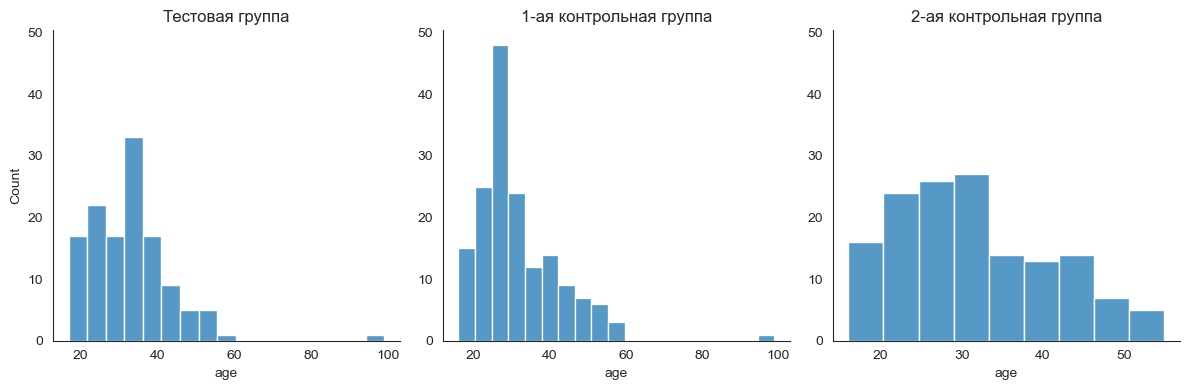

In [188]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

sns.histplot(x = users_test.age, ax = axes[0])
axes[0].set(title = 'Тестовая группа')

sns.histplot(x = users_control_1.age, ax = axes[1])
axes[1].set(title = '1-ая контрольная группа', ylabel = '')

sns.histplot(x = users_control_2.age, ax = axes[2])
axes[2].set(title = '2-ая контрольная группа', ylabel = '')

# Найдем максимальное значение плотности (или частоты) по оси Y для всех графиков
max_y = max(
            axes[0].get_ylim()[1],  # Максимум по Y для первого графика
            axes[1].get_ylim()[1],  # Максимум по Y для второго графика
            axes[2].get_ylim()[1]   # Максимум по Y для третьего графика
           )
# Устанавливаем одинаковый предел для оси Y на всех графиках
for ax in axes:
    ax.set_ylim(0, max_y)

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

##### Средние и медианные значения возраста по группам

###### По пользователям в тестовой группе:

In [131]:
print(f'''Возрастной показатель по пользователям в тестовой группе:
средний возраст   = {round(users_test.age.mean(),3)}
медианный возраст = {round(users_test.age.median(),3)}''')

Возрастной показатель по пользователям в тестовой группе:
средний возраст   = 32.835
медианный возраст = 33.0


###### По пользователям в 1-ой контрольной группе:

In [136]:
print(f'''Возрастной показатель по пользователям в 1-ой контрольной группе:
средний возраст   = {round(users_control_1.age.mean(),3)}
медианный возраст = {round(users_control_1.age.median(),3)}''')

Возрастной показатель по пользователям в 1-ой контрольной группе:
средний возраст   = 31.793
медианный возраст = 29.0


###### По пользователям во 2-ой контрольной группе:

In [134]:
print(f'''Возрастной показатель по пользователям во 2-ой контрольной группе:
средний возраст   = {round(users_control_2.age.mean(),3)}
медианный возраст = {round(users_control_2.age.median(),3)}''')

Возрастной показатель по пользователям во 2-ой контрольной группе:
средний возраст   = 31.473
медианный возраст = 30.0


##### Проверка группы на **гомоскедастичность**:

- $H_0$: equal_var = True - дисперсии равны, 
- $H_1$: дисперсии различны


Гомоскедастичность — когда разброс ошибок модели одинаковый для всех значений. Т.е. ошибки не становятся больше или меньше в зависимости от предсказанных значений.

In [137]:
pg.homoscedasticity(data = users_merged, dv = 'age', group = 'group')

,W,pval,equal_var
levene,0.107369,0.898218,True


Тест на гомоскедастичность показал, что дисперсии в группах статистически не отличаются =>  анализ основных предположений линейной регрессии не нарушает.

##### Так как у нас 3 группы с количественными переменными - сравним их распределения с помощью критерия Краскела-Уоллиса:

- $H_0$: между распределениями возраста в тестовой и контрольных группах нет статистически значимых различий (p-value > 0.05)
- $H_1$: между распределениями возраста в тестовой и контрольных группах есть статистически значимые различия.

In [139]:
kruskal(users_merged.query('group == "test"').age, users_merged.query('group == "control_1"').age, users_merged.query('group == "control_2"').age)

KruskalResult(statistic=1.8616835221800525, pvalue=0.39422173015390216)

Согласно статистике (p-value > 0.05), мы не можем отклонить нулевую гипотезу об отсутствии различий в распределениях возраста между тестовой и контрольными группами. 

Это позволяет нам считать возрастное распределение в группах одинаковым, что подтверждает репрезентативность выборок по данному признаку ✅

Основная возрастная категория — молодежь (25-35 лет), средний возраст пользователей составляет 32 года.

##### Распределение пользователей в зависимости от коэффициента привлекательности attraction_coeff

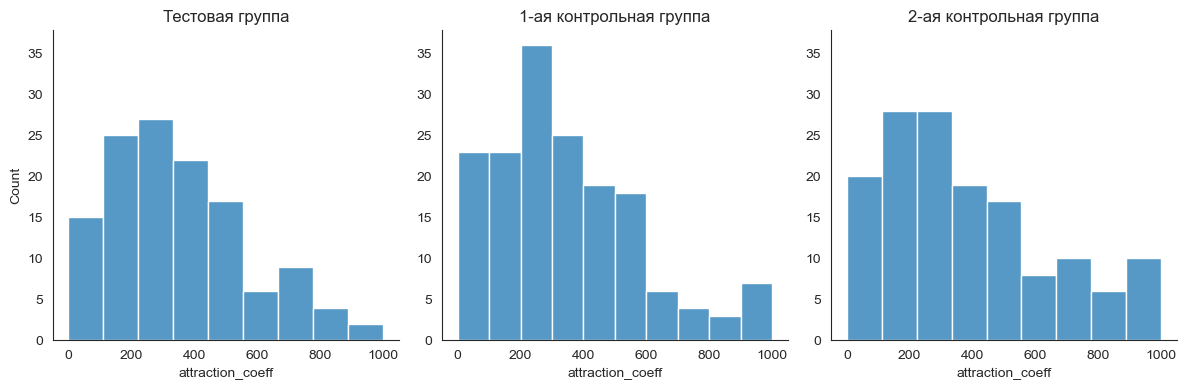

In [148]:
# Распределение пользователей в зависимости от коэффициента привлекательности attraction_coeff (от 0 до 1000, лайки / просмотры * 1000)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Строим гистограммы для разных групп
sns.histplot(x=users_test.attraction_coeff, ax=axes[0])
axes[0].set(title='Тестовая группа')

sns.histplot(x=users_control_1.attraction_coeff, ax=axes[1])
axes[1].set(title='1-ая контрольная группа', ylabel='')

sns.histplot(x=users_control_2.attraction_coeff, ax=axes[2])
axes[2].set(title='2-ая контрольная группа', ylabel='')

# Найдем максимальное значение плотности (или частоты) по оси Y для всех графиков
max_y = max(
            axes[0].get_ylim()[1],  # Максимум по Y для первого графика
            axes[1].get_ylim()[1],  # Максимум по Y для второго графика
            axes[2].get_ylim()[1]   # Максимум по Y для третьего графика
           )
# Устанавливаем одинаковый предел для оси Y на всех графиках
for ax in axes:
    ax.set_ylim(0, max_y)

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

In [151]:
# Посмотрим на средние значения 
users_test.attraction_coeff.mean()

353.13385826771656

##### Средние и медианные значения коэффициента привлекательности по группам

###### По пользователям в тестовой группе:

In [153]:
print(f'''Показатель коэффициента привлекательности по пользователям в тестовой группе:
средний   = {round(users_test.attraction_coeff.mean(),3)}
медианный = {round(users_test.attraction_coeff.median(),3)}''')

Показатель коэффициента привлекательности по пользователям в тестовой группе:
средний   = 353.134
медианный = 328.0


###### По пользователям в 1-ой контрольной группе:

In [154]:
print(f'''Показатель коэффициента привлекательности по пользователям в 1-ой контрольной группе:
средний   = {round(users_control_1.attraction_coeff.mean(),3)}
медианный = {round(users_control_1.attraction_coeff.median(),3)}''')

Показатель коэффициента привлекательности по пользователям в 1-ой контрольной группе:
средний   = 339.622
медианный = 298.0


###### По пользователям во 2-ой контрольной группе:

In [155]:
print(f'''Показатель коэффициента привлекательности по пользователям во 2-ой контрольной группе:
средний   = {round(users_control_2.attraction_coeff.mean(),3)}
медианный = {round(users_control_2.attraction_coeff.median(),3)}''')

Показатель коэффициента привлекательности по пользователям во 2-ой контрольной группе:
средний   = 381.726
медианный = 323.5


##### Проверка на гомоскедастичность

In [156]:
pg.homoscedasticity(data = users_merged, dv = 'attraction_coeff', group = 'group')

,W,pval,equal_var
levene,2.508938,0.082534,True


##### Так как у нас 3 группы с количественными переменными - сравним их распределения с помощью критерия Краскела-Уоллиса:

- $H_0$: между распределениями коэффициента привлекательности в тестовой и контрольных группах нет статистически значимых различий (p-value > 0.05)
- $H_1$: между распределениями коэффициента привлекательности в тестовой и контрольных группах есть статистически значимые различия.

In [157]:
kruskal(users_merged.query('group == "test"').attraction_coeff, users_merged.query('group == "control_1"').attraction_coeff, users_merged.query('group == "control_2"').attraction_coeff)

KruskalResult(statistic=1.3258233628683038, pvalue=0.5153486168360484)

Средний коэффициент привлекательности пользователей в группах составляет от 340 до 382 (максимум — 1000).

Согласно статистике (p-value > 0.05), мы не можем отклонить нулевую гипотезу об отсутствии различий в распределениях коэффициента привлекательности между тестовой и контрольными группами. Это позволяет нам считать распределения в группах одинаковыми, что подтверждает репрезентативность выборок по данному признаку ✅

##### Распределение пользователей в зависимости от количества внутренней валюты (coins)

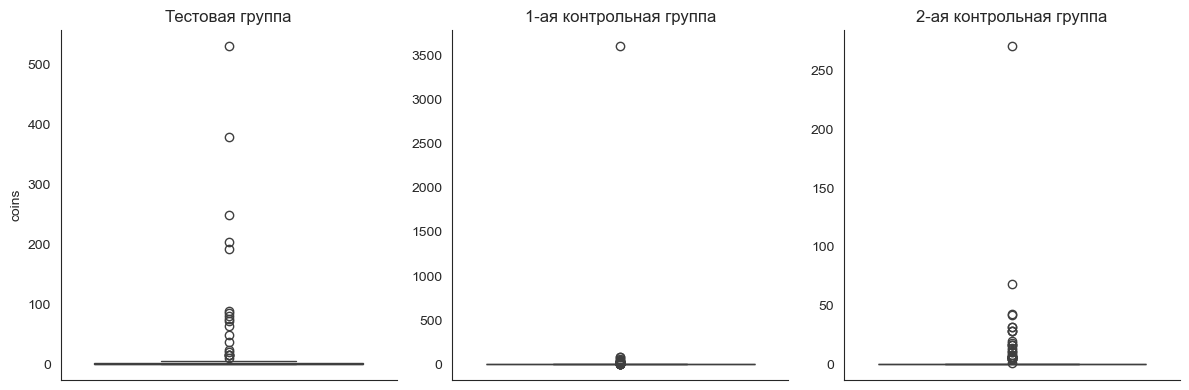

In [161]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

sns.boxplot(y = users_test.coins, ax = axes[0])
axes[0].set(title = 'Тестовая группа')

sns.boxplot(y = users_control_1.coins, ax = axes[1])
axes[1].set(title = '1-ая контрольная группа', ylabel = '')

sns.boxplot(y = users_control_2.coins, ax = axes[2])
axes[2].set(title = '2-ая контрольная группа', ylabel ='')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

В **1-ой контрольной группе** есть **выброс** - изучим:

In [162]:
users_control_1.query('coins == coins.max()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1


In [163]:
transactions_control_1.query('uid == 892333905')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147,no_sympathy,premium_no_trial,control_2


Скачек наблюдается только у одного пользователя, его данные не должны существенно повлиять на результаты анализа

##### Проверка на гомоскедастичность

In [166]:
pg.homoscedasticity(data = users_merged, dv = 'coins', group = 'group')

,W,pval,equal_var
levene,0.547366,0.57887,True


##### Так как у нас 3 группы с количественными переменными - сравним их распределения с помощью критерия Краскела-Уоллиса:

- $H_0$: между распределениями количества внутренней валюты в тестовой и контрольных группах нет статистически значимых различий (p-value > 0.05)
- $H_1$: между распределениями количества внутренней валюты в тестовой и контрольных группах есть статистически значимые различия.

In [167]:
kruskal(users_merged.query('group == "test"').coins, users_merged.query('group == "control_1"').coins, users_merged.query('group == "control_2"').coins)

KruskalResult(statistic=1.2617925744049447, pvalue=0.5321146596513002)

Так как наше p-value > 0.05, мы не можем отвергнуть нулевую гипотезу. Это означает, что различий между распределениями количества внутренней валюты пользователей в разных группах нет, что свидетельствует о репрезентативности выборок по этому признаку ✅

##### Распределение пользователей в зависимости от страны 

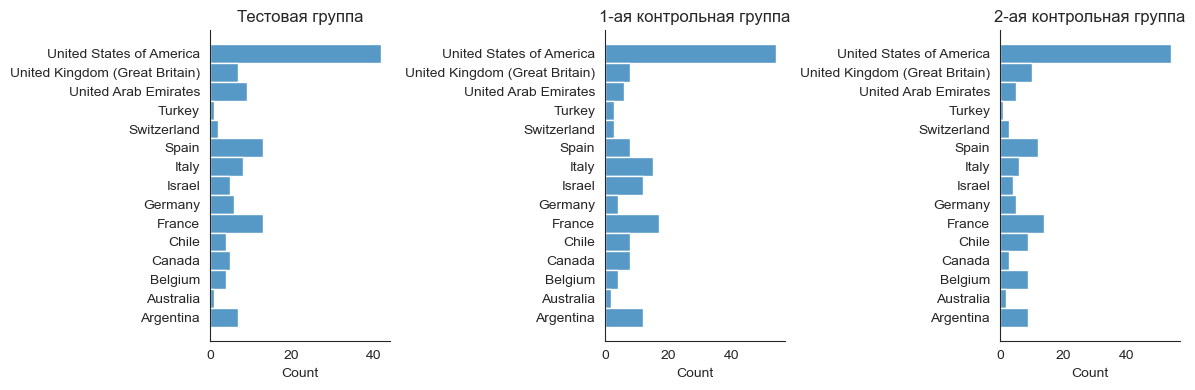

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Строим гистограммы для разных групп
sns.histplot(y=users_test.country.sort_values(ascending=False), ax = axes[0])
axes[0].set(title='Тестовая группа', ylabel='')

sns.histplot(y=users_control_1.country.sort_values(ascending=False), ax = axes[1])
axes[1].set(title='1-ая контрольная группа', ylabel='')

sns.histplot(y=users_control_2.country.sort_values(ascending=False), ax = axes[2])
axes[2].set(title='2-ая контрольная группа', ylabel='')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

##### Сравнение распределения с помощью статистического теста

Поскольку у нас есть категориальные переменные (страна, группа пользователя) => используем тест хи-квадрат:

- $H_0$: нет статистически значимой разницы между распределениями пользователей по странам в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределениями пользователей по странам в тестовой и контрольных группах.

In [170]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merged.country, users_merged.group))
stat, p

(21.86910075724715, 0.7873150709907116)

Распределение пользователей по странам, согласно графикам, примерно одинаково в тестовой и контрольных группах, с преобладанием пользователей из США.

Согласно результатам статистического теста (p-value > 0.05), мы не смогли отклонить нулевую гипотезу. Статистически значимой разницы между распределениями пользователей по странам в тестовой и контрольных группах не обнаружено, что подтверждает репрезентативность выборок по этому признаку ✅

##### Распределение пользователей в зависимости от пола

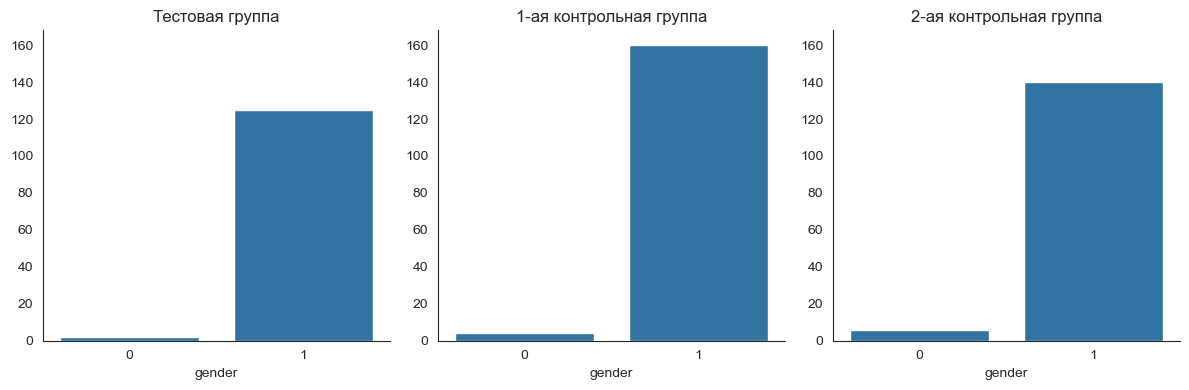

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.countplot(data=users_test, x = 'gender', ax = axes[0])
axes[0].set(title='Тестовая группа', ylabel='')

sns.countplot(data=users_control_1, x = 'gender', ax = axes[1])
axes[1].set(title='1-ая контрольная группа', ylabel='')

sns.countplot(data=users_control_2, x = 'gender', ax = axes[2])
axes[2].set(title='2-ая контрольная группа', ylabel='')

# Найдем максимальное значение плотности (или частоты) по оси Y для всех графиков
max_y = max(
            axes[0].get_ylim()[1],  # Максимум по Y для первого графика
            axes[1].get_ylim()[1],  # Максимум по Y для второго графика
            axes[2].get_ylim()[1]   # Максимум по Y для третьего графика
           )
# Устанавливаем одинаковый предел для оси Y на всех графиках
for ax in axes:
    ax.set_ylim(0, max_y)

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

Распределение пользователей во всех группах примерно одинаковое, с преобладанием группы под номером 1. 

Скорее всего, группа 1 соответствует мужчинам, а 0 — женщинам, поскольку в дейтинг-приложениях, согласно статистике, мужской пол обычно преобладает.

##### Сравним распределения с помощью статистического теста

Есть категориальные переменные (пол, группа пользователя) => нужен хи-квадрат

- $H_0$: нет статистически значимой разницы между распределениями пользователей по половому признаку в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимая разница между распределениями пользователей по половому признаку в тестовой и контрольных группах

In [173]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merged.gender, users_merged.group))
stat, p

(1.72669415296182, 0.4217480941477504)

Согласно результатам статистического теста (p-value > 0.05), не обнаружена статистически значимая разница между распределениями пользователей по половому признаку в тестовой и контрольных группах, что подтверждает репрезентативность выборок по этому признаку ✅

##### Распределение числа оценок пользователей по группам

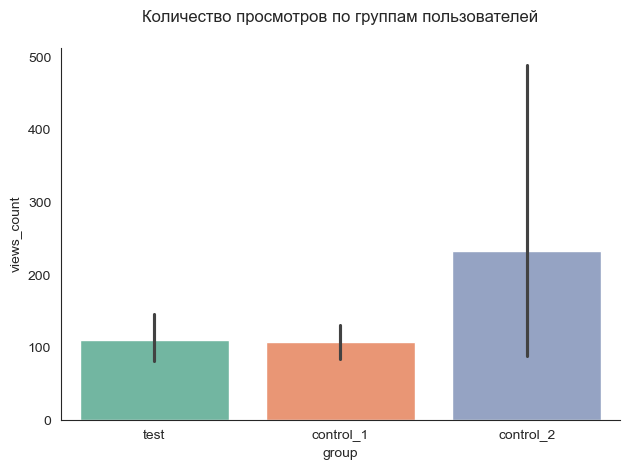

In [184]:
# Строим диаграмму
sns.barplot(data = users_merged, x='group', y='views_count', palette='Set2') 
plt.title('Количество просмотров по группам пользователей\n')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

##### Проверка на гомоскедастичность

In [185]:
pg.homoscedasticity(data = users_merged, dv = 'views_count', group = 'group')

,W,pval,equal_var
levene,1.271269,0.281518,True


##### Так как у нас 3 группы с количественными переменными - сравним их распределения с помощью критерия Краскела-Уоллиса:

- $H_0$: нет статистически значимых различий между распределениями количества просмотров в тестовой и контрольных группах (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями количества  просмотров в тестовой и контрольных группах

In [187]:
kruskal(users_merged.query('group == "test"').views_count, \
        users_merged.query('group == "control_1"').views_count, users_merged.query('group == "control_2"').views_count)

KruskalResult(statistic=1.9364385074056973, pvalue=0.37975869022377584)

Наше p-value > 0.05, поэтому мы не можем отвергнуть нулевую гипотезу. 

Это означает, что статистически значимых различий между распределениями количества просмотров пользователей в разных группах нет, что подтверждает репрезентативность выборок по данному признаку ✅

#### **Таким образом, проверив наши выборки по нескольким признакам, мы убедились в их репрезентативности и наличии корректного разделения пользователей по группам**✅

## **3. Проведение A/A/B тестов**

Для оценки эффективности эксперимента по изменению стоимости премиум-подписки основным ориентиром будет изменение **ARPPU_pr** (**среднего дохода на платящего премиум пользователя**), поскольку эксперименты касаются именно премиум пользователей, доход от которых имеет важное значение для бизнеса.

- $H_0$: ARPPU_pr в тестовой группе существенно больше, чем в контрольных группах.
- $H_1$: ARPPU_pr в тестовой группе существенно меньше, чем в контрольных группах, или не изменился.

Также следует учесть такие экономические метрики:

- CR_pr (конверсия пользователей в покупку премиум подписки, поскольку все пользователи в выборках уже являются покупателями),
- ARPPU (средний доход на платящего пользователя, не включающего премиум подписку).

Поскольку в наших выборках все пользователи являются платящими, ARPPU и ARPPU_pr будут рассчитываться как доход на одного платящего пользователя и доход от платящего пользователя премиум подписки соответственно.

**Эти метрики тесно связаны с ARPPU_pr, поэтому их изменение должно быть учтено в ходе анализа.**

**Дополнительно будет проведен анализ таких показателей, как:**

- Соотношение пользователей, продливших и не продливших премиум подписку 

**Стоимость подписки может влиять на готовность пользователей продлевать её, что, в свою очередь, повлияет на количество премиум пользователей и общий доход.**

- Количество дней посещений (visit days)
    
Есть предположение, что увеличение стоимости подписки может повлиять на количество посещений приложения, поскольку пользователи, заплатившие большую сумму, будут более мотивированы оправдать эти затраты частыми посещениями. Это может повысить доход от таких пользователей.

**Хоть эти метрики и имеют косвенное влияние, они могут значительно повлиять на ARPPU_pr и, соответственно, на результаты эксперимента.**

#### Проведем **А/А тестирование** для контрольных групп **перед запуском А/В теста**

##### В начале проверим группы на гомоскедастичность

In [189]:
pg.homoscedasticity(data = users_merged.query('total_revenue > 0 and group != "test"'), dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.737499,0.391133,True


##### Будем использовать t-тест для сравнения средних значений ARPPU в двух выборках:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU в контрольных группах
- $H_1$: есть статистически значимые различия между средними значениями ARPPU в контрольных группах

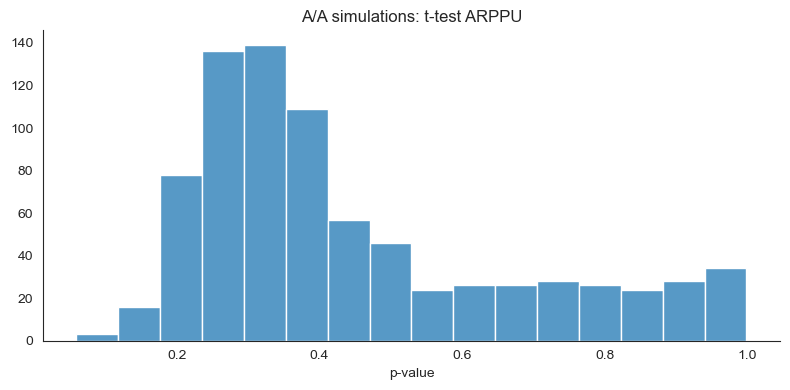

In [190]:
df = []

for i in range(800):
    c_1 = users_control_1.query('total_revenue > 0').total_revenue.sample(100, replace = False).values
    c_2 = users_control_2.query('total_revenue > 0').total_revenue.sample(100, replace = False).values
    df.append(ttest_ind(c_1, c_2, equal_var = False)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(df)
axes.set(title = 'A/A simulations: t-test ARPPU', xlabel = 'p-value', ylabel = '')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

In [192]:
# Проверим, что количество ложноположительных случаев не превышает уровень значимости (0.05)
((np.array(df) < 0.05) / 800).sum() <= 0.05

True

Нулевую гипотезу отвергнуть не удалось, что означает отсутствие статистически значимых различий по ARPPU в контрольных группах.

Таким образом, в А/В тестах будем использовать только одну контрольную группу — "control_2", так как эта выборка претерпела меньше изменений в предобработке по сравнению с группой "control_1".

##### Соберем данные о пользователях, которые продлили и не продлили подписку

In [193]:
users_premium = users_merged[['uid', 'was_premium', 'is_premium', 'group']].query('group != "control_1"')
users_premium.head()

,uid,was_premium,is_premium,group
20,891152790,1.0,1.0,test
44,891589239,1.0,1.0,test
100,891343671,1.0,1.0,test
105,892430988,1.0,1.0,test
134,891919368,1.0,1.0,test


In [194]:
users_premium.query('was_premium == 0.0 and is_premium == 1.0').shape[0]

0

Пользователей, у которых не было подписки, а она появилась, нет (что логично), поэтому разделим пользователей на 3 группы:

In [197]:
# Функция, которая добавляет столбец 'premium', который отражает статус пользователя: был ли он премиум, отменил ли подписку или не был премиум.

def f(row):
    if row['was_premium'] == 0.0 and row['is_premium'] == 0.0:
        x = 'no'
    elif row['was_premium'] == 1.0 and row['is_premium'] == 0.0:
        x = 'canceled'
    else:
        x = 'not canceled'
    return x

users_premium['premium'] = users_premium.apply(f, axis = 1)
users_premium.head()

,uid,was_premium,is_premium,group,premium
20,891152790,1.0,1.0,test,not canceled
44,891589239,1.0,1.0,test,not canceled
100,891343671,1.0,1.0,test,not canceled
105,892430988,1.0,1.0,test,not canceled
134,891919368,1.0,1.0,test,not canceled


In [198]:
users_premium.groupby(['group', 'premium']).size()

group      premium     
control_2  canceled         10
           not canceled    136
test       canceled          7
           not canceled    120
dtype: int64

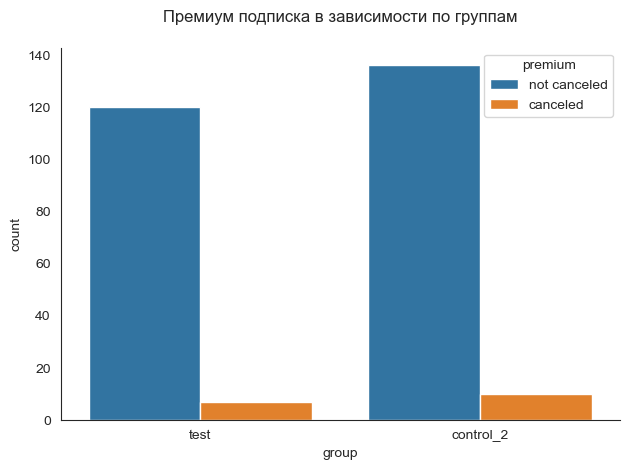

In [199]:
# Визуацизация распределений
sns.countplot(data=users_premium, x = 'group', hue = 'premium')

plt.title('Премиум подписка в зависимости по группам\n')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

Визуальные различия незначительны. Проведем статистическую проверку:

Поскольку переменные категориальные (подписка: продлили/не продлили и группа пользователя), применим критерий хи-квадрат:

- $H_0$: нет статистически значимой разницы между распределениями пользователей по статусу подписки (продлили/не продлили) в тестовой и контрольной группах (p-value > 0.05).
- $H_1$: существует статистически значимая разница между распределениями пользователей по статусу подписки в тестовой и контрольной группах.

In [200]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_premium.premium, users_premium.group))
stat, p

(0.04205977241354288, 0.8375058771665312)

In [202]:
# Проверим статистику с использованием библиотеки Pingouin
exp, obs, stats = pg.chi2_independence(data = users_premium, 
                                          x = 'group', 
                                          y = 'premium') 
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.042060,1.0,0.837506,0.012412,0.054832
1,cressie-read,0.666667,0.042093,1.0,0.837443,0.012417,0.054836
2,log-likelihood,0.000000,0.042163,1.0,0.837309,0.012428,0.054844
3,freeman-tukey,-0.500000,0.042221,1.0,0.837199,0.012436,0.054851
4,mod-log-likelihood,-1.000000,0.042283,1.0,0.837081,0.012445,0.054858
5,neyman,-2.000000,0.042418,1.0,0.836824,0.012465,0.054873


Согласно статистике (p-value > 0.05) нулевую гипотезу об отсутствии разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе мы отклонить не можем.

##### Сравним количество дней посещений пользователей в зависимости от группы (visit days)

Для начала преобразуем колонку с номерами дней в необходимый формат

In [203]:
users_merged['visit_days'] = users_merged['visit_days'].str.split(',\s*')

In [204]:
# Добавляем колонку с количеством дней посещения пользователей
users_merged['days_count'] = users_merged.visit_days.str.len()

In [205]:
# Меняем NaN на нули и изменяем тип данных на int
users_merged['days_count'] = users_merged['days_count'].fillna(0).astype(int)

In [207]:
# Среднее количество дней посещения
round(users_merged.groupby('group', as_index = False).agg({'days_count' : 'mean'}), 2)

,group,days_count
0,control_1,9.71
1,control_2,9.29
2,test,9.24


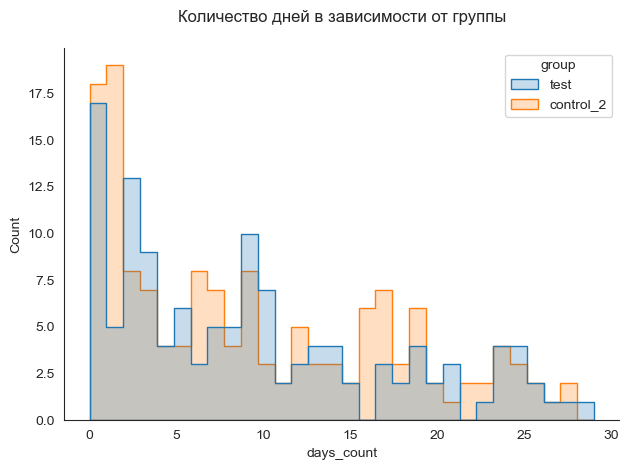

In [208]:
# Визуализация 
sns.histplot(data = users_merged.query('group != "control_1"'), hue = 'group', x = 'days_count', bins = 30, element='step')

plt.title('Количество дней в зависимости от группы\n')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

Визуальных различий значительных не наблюдается. Проведем статистическую проверку.

##### Проверка на гомоскедастичность

In [209]:
pg.homoscedasticity(data = users_merged, dv = 'days_count', group = 'group')

,W,pval,equal_var
levene,0.156987,0.854764,True


##### Т.к. у нас 2 группы, сравним их распределения при помощи критерия Манна-Уитни:

- $H_0$: нет статистически значимых различий между распределениями количества посещений в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между распределениями количества посещений в тестовой и контрольной группе

In [210]:
mannwhitneyu(users_merged.query('group == "test"').days_count, users_merged.query('group == "control_2"').days_count)

MannwhitneyuResult(statistic=9358.0, pvalue=0.8940167190188826)

P-value > 0.05, следовательно, нулевую гипотезу отклонить не удается. 

Это свидетельствует о том, что статистически значимых различий в распределении количества посещений между тестовой и контрольной группами нет. 

Изменение стоимости премиум-подписки не оказало влияния на частоту посещений приложения пользователями.

##### Рассчет экономических метрик для тестовой и контрольной групп и подготовим сводную таблицу

In [211]:
metrics = []

users         = users_test.uid.nunique()
premium_users = transactions_test.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue       = transactions_test.revenue.sum()
CR_pr         = (premium_users / users)
ARPPU         = (revenue / users)
ARPPU_pr      = (revenue / premium_users)

metrics.append(pd.DataFrame(index = ['test'],       \
                            data  = {'users':users, \
                                     'premium_users':premium_users, 
                                     'CR_pr':CR_pr, \
                                     'ARPPU':ARPPU, \
                                     'ARPPU_pr':ARPPU_pr}
                           ))
metrics = pd.concat(metrics)
metrics

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.511811,12868.259843,25142.6


In [212]:
metrics_1 = []

users         = users_control_2.uid.nunique()
premium_users = transactions_control_2.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue       = transactions_control_2.revenue.sum()
CR_pr         = (premium_users / users)
ARPPU         = (revenue / users)
ARPPU_pr      = (revenue / premium_users)

metrics_1.append(pd.DataFrame(index = ['control_2'],  \
                              data  = {'users':users, \
                                     'premium_users':premium_users, 
                                     'CR_pr':CR_pr,   \
                                     'ARPPU':ARPPU,   \
                                     'ARPPU_pr':ARPPU_pr}
                           ))
metrics_1 = pd.concat(metrics_1)
metrics_1

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
control_2,146,95,0.650685,9038.650685,13890.978947


In [214]:
# Объединение и округление значений
metrics_merged = pd.concat([metrics, metrics_1])

metrics_merged[['CR_pr']] = metrics_merged[['CR_pr']].round(4)
metrics_merged[['ARPPU', 'ARPPU_pr']] = metrics_merged[['ARPPU', 'ARPPU_pr']].round(2)
metrics_merged

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.5118,12868.26,25142.60
control_2,146,95,0.6507,9038.65,13890.98


In [215]:
# Выделение максимальных и минимальных значений метрик цветом
(metrics_merged
 .style
 .format('{:.4f}', subset = ['CR_pr'])
 .format('{:.2f}', subset = ['ARPPU', 'ARPPU_pr'])
 .highlight_max(color='yellowgreen', subset = ['CR_pr', 'ARPPU', 'ARPPU_pr'])
 .highlight_min(color='coral', subset       = ['CR_pr', 'ARPPU', 'ARPPU_pr'])
)

,users,premium_users,CR_pr,ARPPU,ARPPU_pr
test,127,65,0.5118,12868.26,25142.60
control_2,146,95,0.6507,9038.65,13890.98


По результатам расчета экономических метрик можно сделать следующие выводы:

В тестовой группе, по сравнению с контрольной, наблюдается снижение метрики CR_pr (конверсия в покупку премиум подписки) на 21%. 

Это свидетельствует о том, что в ходе эксперимента покупка премиум подписки стала реже, что, вероятно, связано с повышением её стоимости.

В то же время в тестовой группе отмечен рост следующих метрик:

- Средний доход на платящего пользователя (+42%),
- Средний доход на платящего премиум пользователя (+82%).

Таким образом, несмотря на снижение числа платящих пользователей, наблюдается значительное улучшение их экономического вклада — доход от каждого пользователя значительно возрос. Эти изменения подтверждают предположение о повышении стоимости премиум подписки.

Выручка увеличилась, однако она включает доход от всех продуктов (пробная премиум-подписка, премиум-подписка, другие типы), в то время как изменение цены касалось только премиум-подписки.

Проведем анализ, чтобы понять, как это увеличение распределяется по различным продуктам, и выявим, за счет какого именно продукта произошел рост дохода.

In [216]:
ARPPU_product_type          = transactions_merged.groupby(['group', 'product_type'], as_index = False).agg({'revenue' : 'sum', 'uid' : 'nunique'})
ARPPU_product_type['ARPPU'] = ARPPU_product_type.revenue / ARPPU_product_type.uid

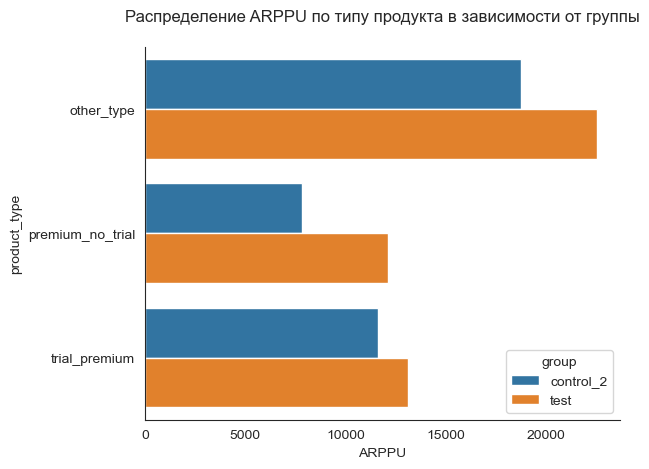

In [217]:
sns.barplot(data=ARPPU_product_type, y='product_type', x='ARPPU', hue='group')

plt.title('Распределение ARPPU по типу продукта в зависимости от группы\n')

sns.despine()      # Убираем лишние элементы и сообщения о вычислениях
plt.tight_layout() # Выравниваем графики
plt.show()         # Показываем графики

По графику видно, что выручка по всем типам продуктов (product_type) в тестовой группе демонстрирует рост по сравнению с контрольной группой, без значительных потерь.

Наибольший рост наблюдается именно для премиум подписки, что подтверждает, что пользователи не стали переключаться на другие платные опции, а продолжили оплачивать премиум подписку, несмотря на ее повышение.

##### Сравним конверсию из пользователя в покупателя премиум подписки (CR_pr) между группами. Поскольку переменные являются номинативными, применим критерий хи-квадрат:

- $H_0$: нет статистически значимой разницы в распределении CR_pr между тестовой и контрольной группами (p-value > 0.05).
- $H_1$: существует статистически значимая разница в распределении CR_pr между тестовой и контрольной группами.

Добавим в данные колонку с конверсией в покупателя премиум подписки в зависимости от типа подписки (product_type)

In [218]:
users_merged['CR_pr'] = users_merged.uid.isin(transactions_merged.query('product_type == "premium_no_trial"').uid.unique()).astype(int)

In [221]:
# Удаляем дубликаты из столбца 'group' и 'CR_pr'
filtered_data = users_merged.query('group != "control_1"').drop_duplicates(subset=['CR_pr', 'group'])
crosstab      = pd.crosstab(filtered_data['CR_pr'], filtered_data['group']) # Создаем кросс-таблицу

stat, p, dof, expected = chi2_contingency(crosstab)                         # Выполняем тест хи-квадрат

print(f"Stat: {stat}, p-value: {p}")                                        # Выводим статистику и p-значение

Stat: 0.0, p-value: 1.0


Так как p < 0.05, мы отвергаем нулевую гипотезу, т.е. есть статистически значимая разница в распределении CR_pr в тестовой и контрольной группе, конверсия в покупателя премиум подписки уменьшилась.

##### Сравним средний доход на платящего пользователя (ARPPU) в группах при помощи статистического F теста:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между средними значениями ARPPU в тестовой и контрольной группе

##### Проверка на гомоскедастичность

In [224]:
pg.homoscedasticity(data = users_merged, dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.543017,0.581387,True


In [225]:
stat, p_value = f_oneway(users_test.total_revenue, users_control_2.total_revenue)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=10.4186, p-value=0.0014


Согласно статистике F-теста (p-value < 0.05) нулевую гипотезу об отсутствии различий между средними значениями ARPPU в тестовой и контрольной группе мы отклоняем, т.е. различия статистически не значимы, значение ARPPU увеличилось.

##### Сравним средний доход на платящего премиум пользователя (ARPPU_pr) в группах при помощи статистического F теста:

- $H_0$: нет статистически значимых различий между средними значениями ARPPU_pr в тестовой и контрольной группе (p-value > 0.05)
- $H_1$: есть статистически значимые различия между средними значениями ARPPU_pr в тестовой и контрольной группе

##### Проверка на гомоскедастичность

In [226]:
pg.homoscedasticity(data = users_merged.query('total_revenue > 0'), dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.538057,0.584272,True


In [227]:
stat, p_value = f_oneway(users_test.query('total_revenue > 0').total_revenue, 
                         users_control_2.query('total_revenue > 0').total_revenue)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=10.4186, p-value=0.0014


p < 0.05, нулевую гипотезу отклоняем, что позволяет заключить, что ARPPU_pr в тестовой группе статистически значимо выше, чем в контрольной группе

## **4. Подведение итогов**

Из предоставленных 6-ти датасетов были отобраны только новые пользователи из нескольких стран, в которых была изменена стоимость премиум-подписки при покупке через две новые платёжные системы.

#### По итоговым выборкам можно сделать следующие выводы:

- Выборки для анализа являются репрезентативными, группы пользователей равномерно распределены по указанным признакам, однако были проведены манипуляции по удалению неподходящих данных и выбросов (в первую очередь в 1-й контрольной группе, поэтому для А/В тестов использовалась 2-я контрольная группа).
- Основная возрастная категория пользователей — молодёжь (25-35 лет), средний возраст — 32 года.
- Средний коэффициент привлекательности пользователей составляет 340-382 (максимум — 1000).
- По географическому признаку преобладают пользователи из США.
- По половому признаку в выборке преобладают мужчины.

#### По результатам проведенных исследований:

- Количество дней посещения приложения статистически значимо не изменилось.
- Количество пользователей, продливших премиум подписку, статистически значимо не изменилось.
- Конверсия в покупку премиум подписки (CR_pr) уменьшилась на 21% (статистически значимо). Это свидетельствует о снижении частоты покупок, что может быть связано с увеличением стоимости подписки, в результате чего часть пользователей отказалась от платных услуг.
- Средний доход на платящего пользователя (ARPPU) увеличился на 42% (статистически значимо), при этом доход увеличился по всем типам продуктов.
- Средний доход на платящего за премиум подписку пользователя (ARPPU_pr) увеличился на 82% (статистически значимо). Это подтверждает, что несмотря на сокращение числа платящих пользователей, их "качество" — доход от них — значительно возрос. Платящие пользователи стали тратить больше, что логично при увеличении стоимости премиум подписки.

## **Вывод**

Таким образом, на основе анализа основной метрики — ARPPU_pr — можно сделать вывод, что **эксперимент был успешным**. 

Изменение стоимости премиум подписки при оплате через две новые платежные системы статистически значимо увеличило ARPPU_pr.

Однако существует риск, что в долгосрочной перспективе снижение конверсии в покупку премиум подписки (CR_pr) может привести к потере платящих пользователей. В этом случае рост ARPPU_pr может не компенсировать уменьшение общего числа платящих пользователей.

**Рекомендуется продолжить внедрение данного обновления, при этом важно регулярно отслеживать экономические показатели и проводить дополнительные анализы для оценки устойчивости изменений.**